<a href="https://colab.research.google.com/github/HuiningLiu02/TIF360-Advanced-machine-learning-with-neural-networks/blob/main/Ch04_AE/hw/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Denoising Images with an Encoder-Decoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_1_denoising/denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [2]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00


This notebook provides you with a complete code example that generates noisy brightfield microscopy images of particles, trains an encoder-decoder to denoise them, and visualizes the results.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-1 from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Generating the Data

Define a spherical particle ...

In [25]:
import deeptrack as dt
import numpy as np

particle = dt.Sphere(
    position=np.array([0.5, 0.5]) * 64, position_unit="pixel",
    radius=lambda: (500 + np.random.rand() * 100) * dt.units.nm, #change the radius
    refractive_index=1.45 + 0.02j,
)

... define the microscope to observe the particle ...

In [26]:
brightfield_microscope = dt.Brightfield(
    wavelength=500 * dt.units.nm, NA=1.0, resolution=1 * dt.units.um,
    magnification=10, refractive_index_medium=1.33, upsample=2,
    output_region=(0, 0, 64, 64),
)

... obtain the image of the microscopic particle ...

In [27]:
illuminated_sample = brightfield_microscope(particle)

... simulate the clean image of the particle ...

In [28]:
import torch

diverse_particle = (illuminated_sample >> dt.NormalizeMinMax()
                  >> dt.MoveAxis(2, 0)
                  >> dt.pytorch.ToTensor(dtype=torch.float))

... simulate the noisy image of the particle ...

In [29]:
noise = dt.Poisson(snr=lambda: 8.0 + np.random.rand() * 2) #imporve the snr to reduce the noise

noisy_particle = (illuminated_sample >> noise >> dt.NormalizeMinMax()
                  >> dt.MoveAxis(2, 0)
                  >> dt.pytorch.ToTensor(dtype=torch.float))

... combine the noisy and clean particle images into a single simulation pipeline ...

In [30]:
diverse_pip = noisy_particle & diverse_particle

... and plot a few noisy and corresponding clean particle images.

In [31]:
import matplotlib.pyplot as plt

def plot_image(title, image):
    """Plot a grayscale image with a title."""
    plt.imshow(image, cmap="gray")
    plt.title(title, fontsize=30)
    plt.axis("off")
    plt.show()

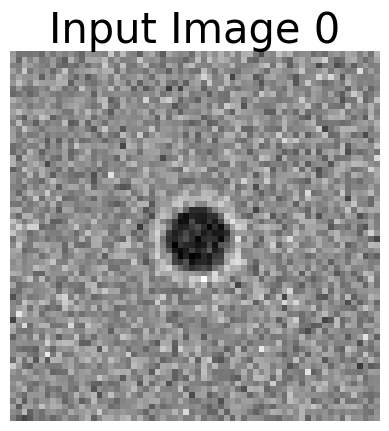

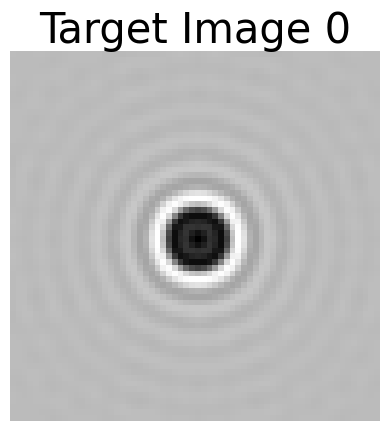

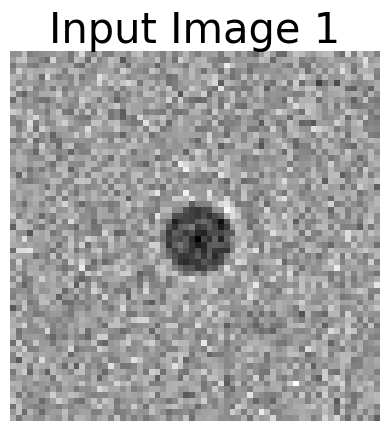

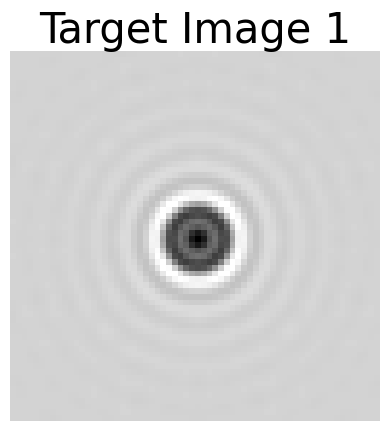

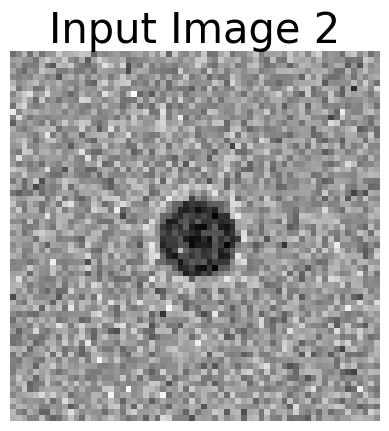

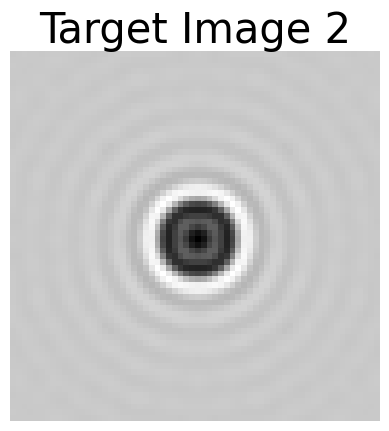

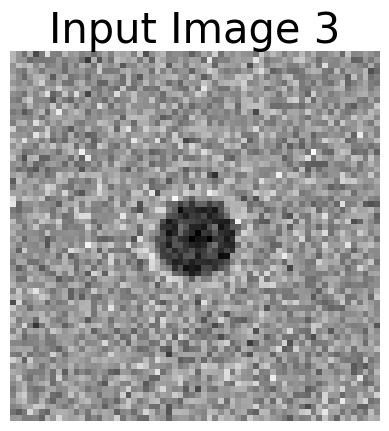

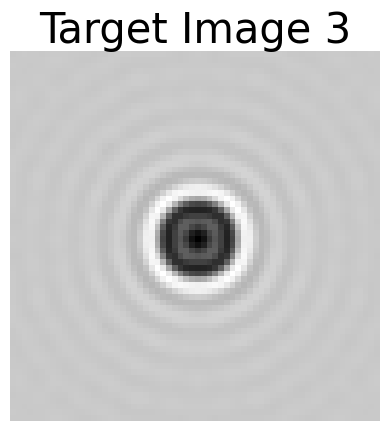

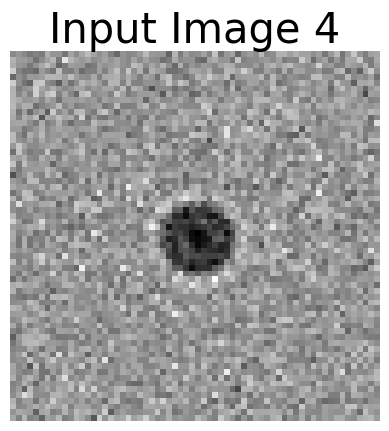

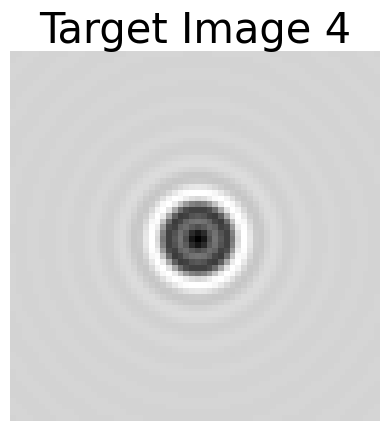

In [32]:
for i in range(5):
    input, target = diverse_pip.update().resolve()
    plot_image(f"Input Image {i}", input.permute(1, 2, 0))
    plot_image(f"Target Image {i}", target.permute(1, 2, 0))

## Creating a Simulated Dataset

Define a class representing a simulated dataset to generate the data for the training of the denoising encoder-decoder ...

In [33]:
class SimulatedDataset(torch.utils.data.Dataset):
    """Simulated dataset simulating pairs of noisy and clean images."""

    def __init__(self, pip, buffer_size, replace=0):
        """Initialize the dataset."""
        self.pip, self.replace = pip, replace
        self.images = [pip.update().resolve() for _ in range(buffer_size)]

    def __len__(self):
        """Return the size of the image buffer."""
        return len(self.images)

    def __getitem__(self, idx):
        """Retrieve a noisy-clean image pair from the dataset."""
        if np.random.rand() < self.replace:
            self.images[idx] = self.pip.update().resolve()
        image_pair = self.images[idx]
        noisy_image, clean_image = image_pair[0], image_pair[1]
        return noisy_image, clean_image

... and create the dataset and the data loader.

In [34]:
dataset = SimulatedDataset(diverse_pip, buffer_size=256, replace=0.1)
loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

## Defining and Training the VAE

Define the variational aotuencoder ...

In [35]:
sample = dataset[0]  # 获取第一个样本
print(sample[0].shape)   # 打印该样本的尺寸
print(sample[1].shape)

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [36]:
import deeplay as dl

encoderdecoder = dl.ConvolutionalEncoderDecoder2d(
    in_channels=1, encoder_channels=[16, 16], out_channels=1,
)

print(encoderdecoder)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2, stride=2)
        (layer): Layer[Conv2d](in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
    (postprocess): Layer[Flatten]()
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_var): Linear(in_features=3136, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): ConvolutionalDecoder2d(
    (blocks): Lay

In [37]:
regressor_template = dl.Regressor(
    model=vae, loss=torch.nn.L1Loss(), optimizer=dl.Adam(),
)
ed = regressor_template.create()

print(ed)

Regressor(
  (loss): L1Loss()
  (optimizer): Adam[Adam]()
  (train_metrics): MetricCollection,
    prefix=train
  )
  (val_metrics): MetricCollection,
    prefix=val
  )
  (test_metrics): MetricCollection,
    prefix=test
  )
  (model): VariationalAutoEncoder(
    (encoder): ConvolutionalEncoder2d(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): Identity()
        )
      )
      (postprocess):

... and train it.

In [39]:
ed_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
ed_trainer.fit(ed, loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name          | Type                   | Params | Mode 
-----------------------------------------------------------------
0 | loss          | L1Loss                 | 0      | train
1 | train_metrics | MetricCollection       | 0      | train
2 | val_metrics   | MetricCollection       | 0      | train
3 | test_metrics  | MetricCollection       | 0      | train
4 | model         | VariationalAutoEncoder | 153 K  | train
5 | optimizer     | Adam                   | 0      | train
-----------------------------------------------------------------
153 K     Trainable params
0         Non-trainable params
153 K     Total params
0.616     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Ty

Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x16384 and 3136x2)

## Testing the Trained Encoder-Decoder

Denoise particle images with the trained encoder-decoder.

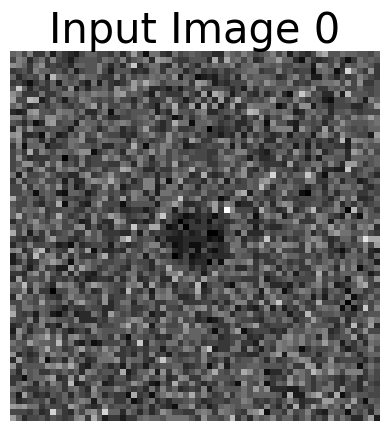

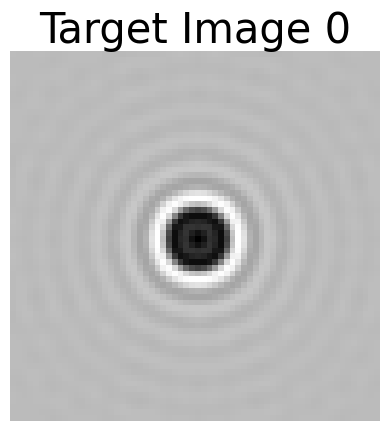

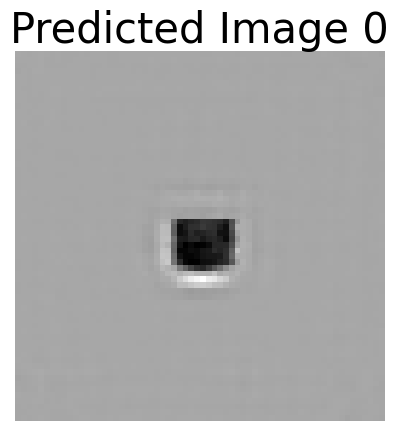

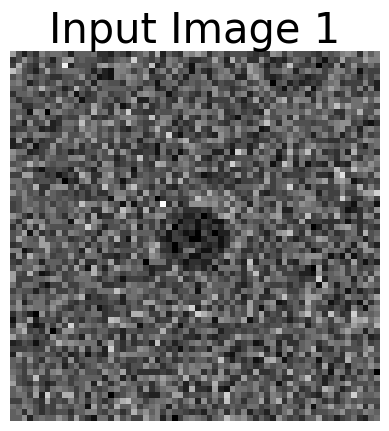

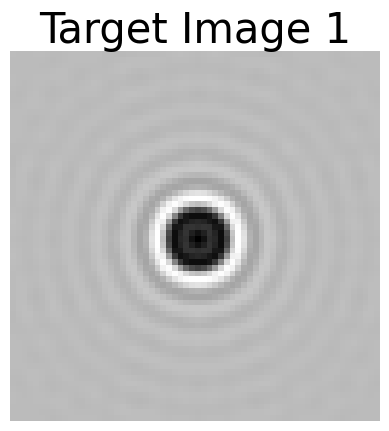

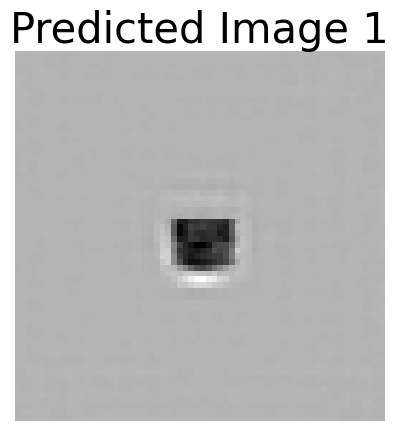

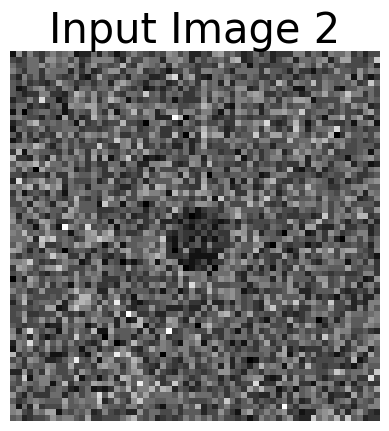

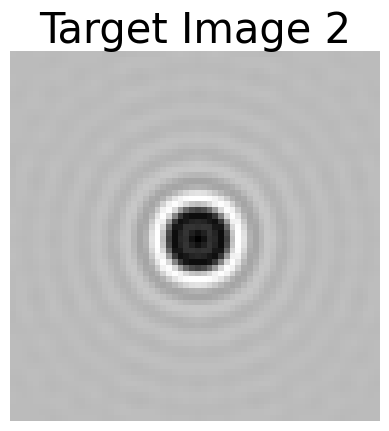

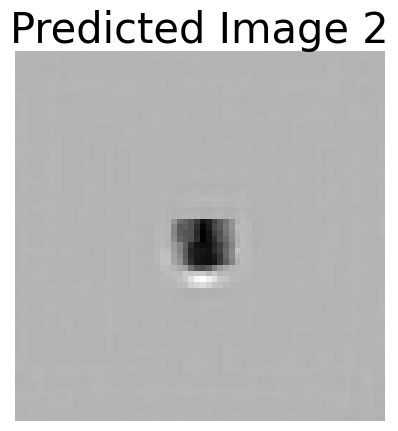

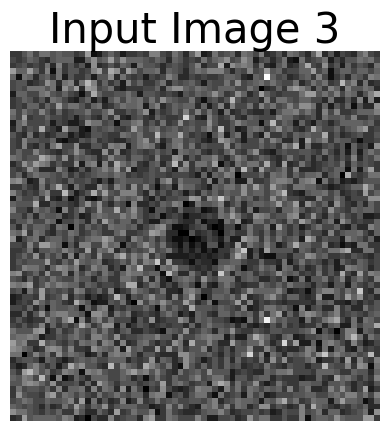

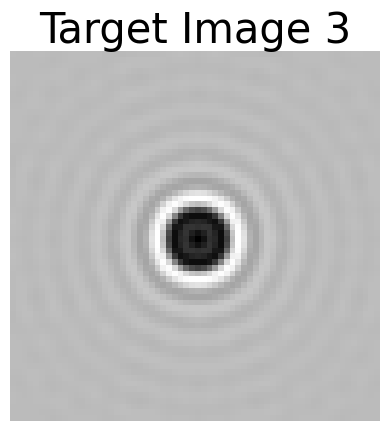

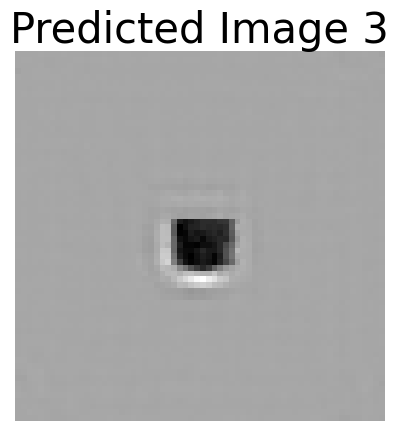

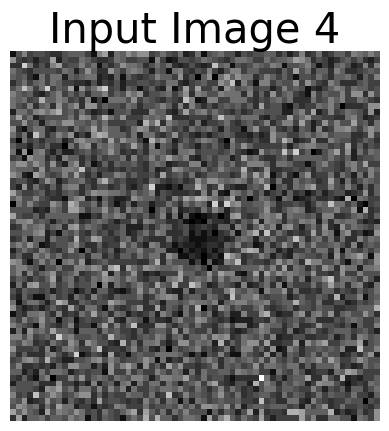

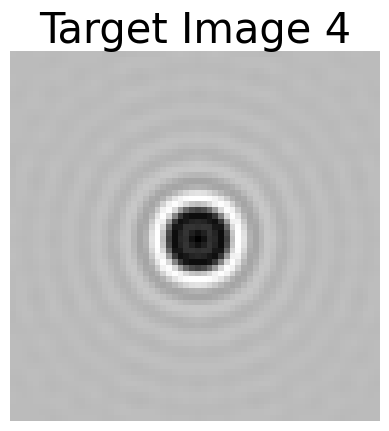

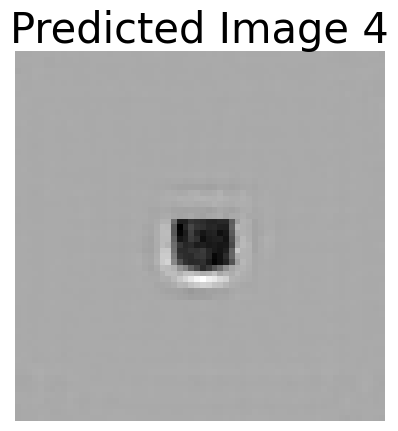

In [ ]:
for i in range(5):
    input, target = pip.update().resolve()
    predicted = ed(input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", input[0, :, :])
    plot_image(f"Target Image {i}", target[0, :, :])
    plot_image(f"Predicted Image {i}", predicted[0, 0, :, :])

## Checking Absence of Mode Collapse

Use the trained encoder-decoder with a blank image.

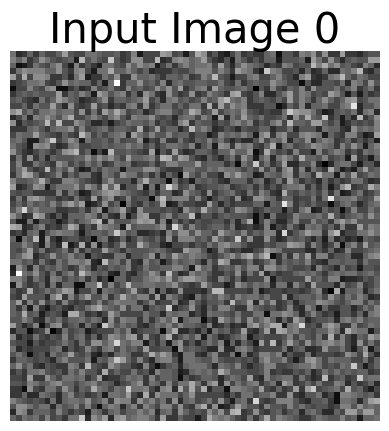

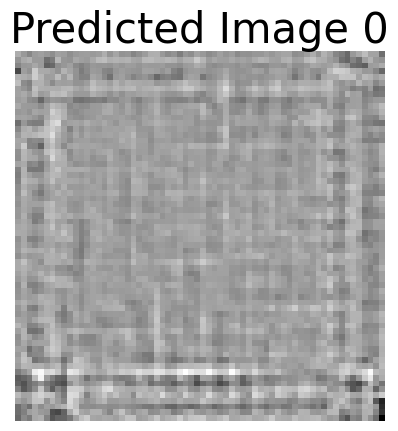

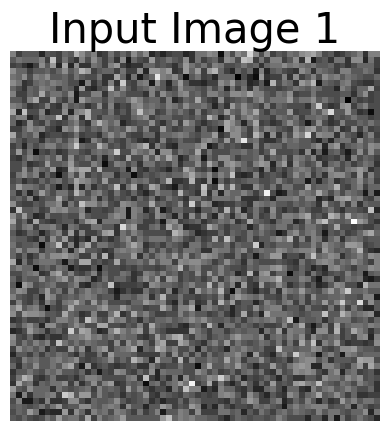

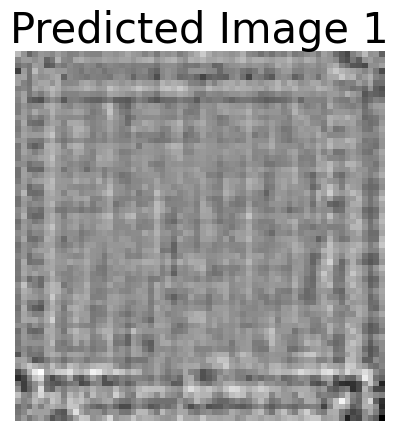

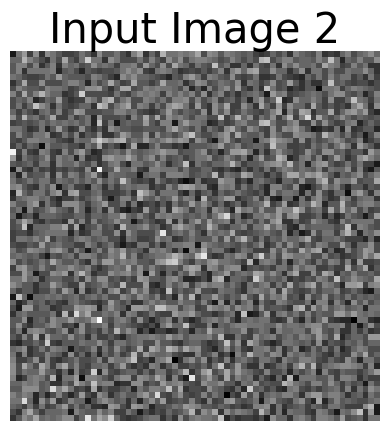

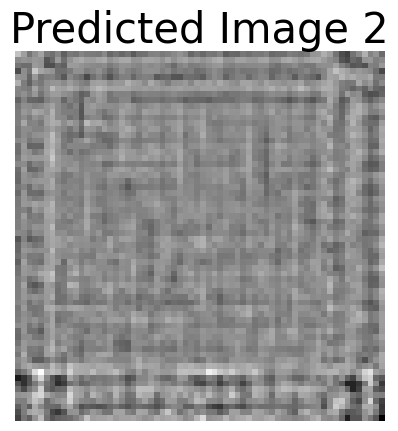

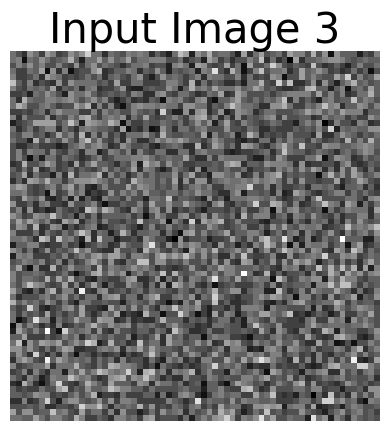

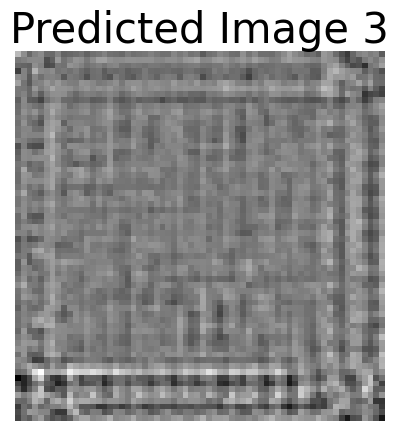

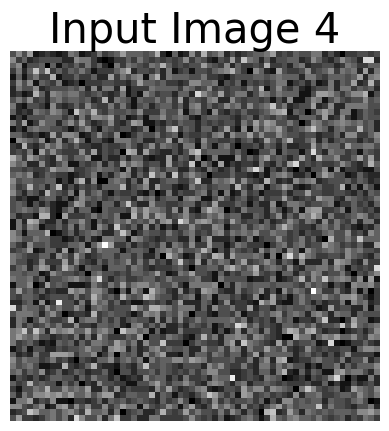

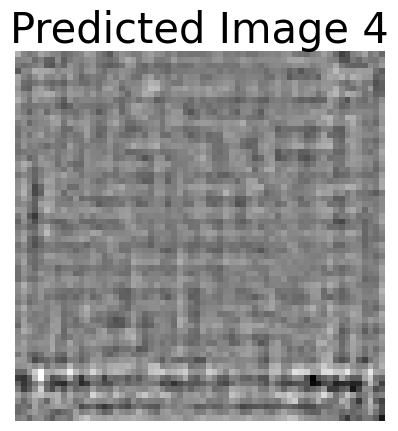

In [ ]:
blank = brightfield_microscope(particle ^ 0)
blank_pip = (blank >> noise >> dt.NormalizeMinMax() >> dt.MoveAxis(2, 0)
             >> dt.pytorch.ToTensor(dtype=torch.float))

for i in range(5):
    blank_image = blank_pip.update().resolve()
    blank_predicted = ed(blank_image.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", blank_image[0, :, :])
    plot_image(f"Predicted Image {i}", blank_predicted[0, 0, :, :])

## Checking Generalization Capabilities

Define a pipeline with a particle with varying position and radius ...

In [ ]:
diverse_particle = dt.Sphere(
    position=lambda: np.array([0.2, 0.2] + np.random.rand(2) * 0.6) * 64,
    radius=lambda: 500 * dt.units.nm * (1 + np.random.rand()),
    position_unit="pixel",
    refractive_index=1.45 + 0.02j,
)
diverse_illuminated_sample = brightfield_microscope(diverse_particle)
diverse_clean_particle = (diverse_illuminated_sample >> dt.NormalizeMinMax()
                          >> dt.MoveAxis(2, 0)
                          >> dt.pytorch.ToTensor(dtype=torch.float))
diverse_noisy_particle = (diverse_illuminated_sample >> noise >> dt.NormalizeMinMax()
                          >> dt.MoveAxis(2, 0)
                          >> dt.pytorch.ToTensor(dtype=torch.float))
diverse_pip = diverse_noisy_particle & diverse_clean_particle

... and denoise images of diverse particles using the trained encoder-decoder.

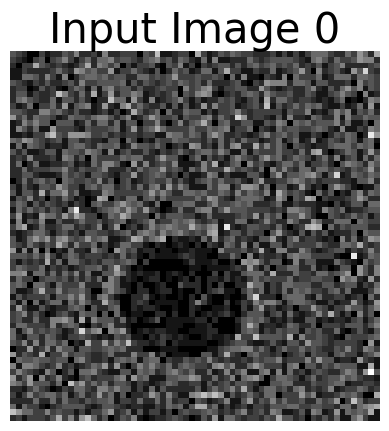

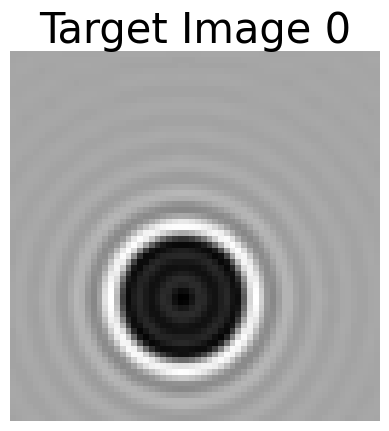

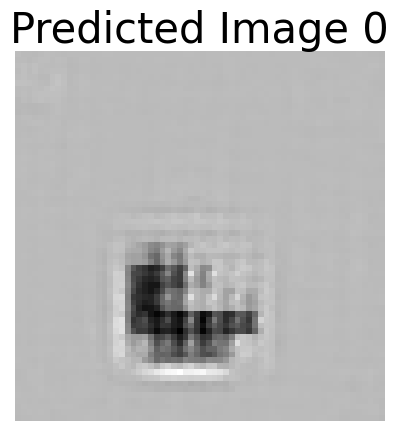

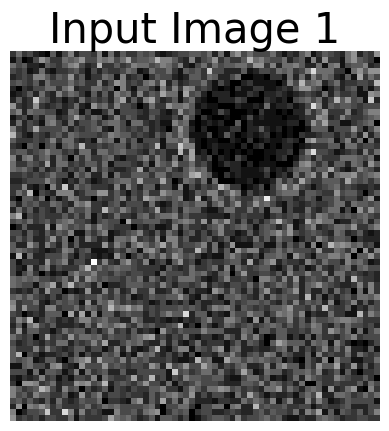

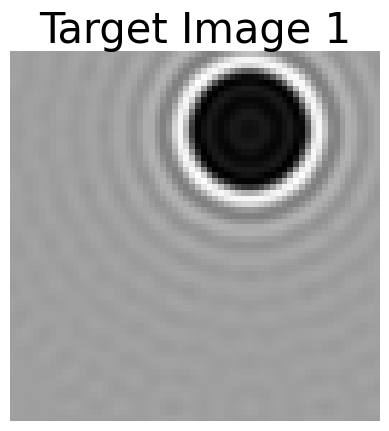

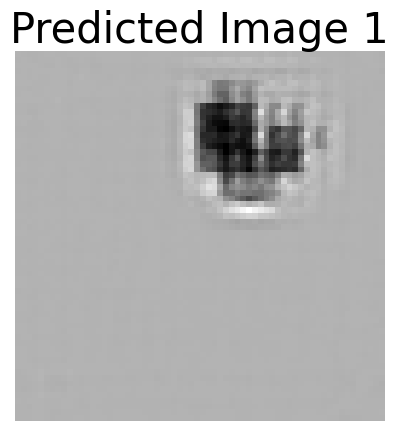

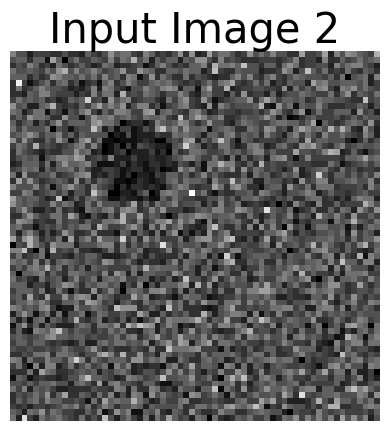

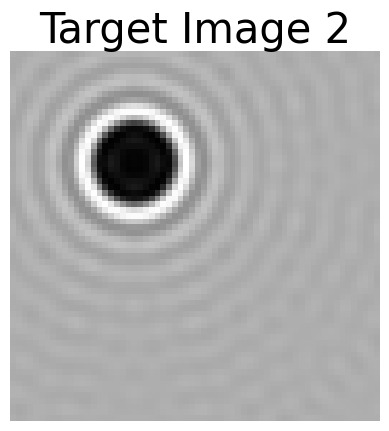

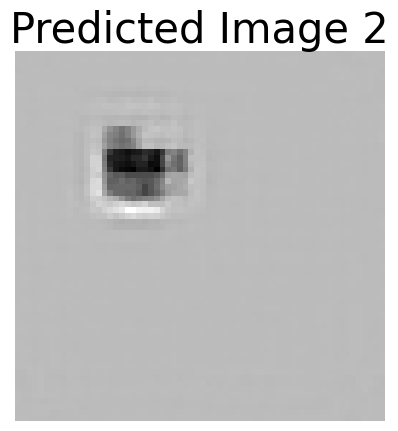

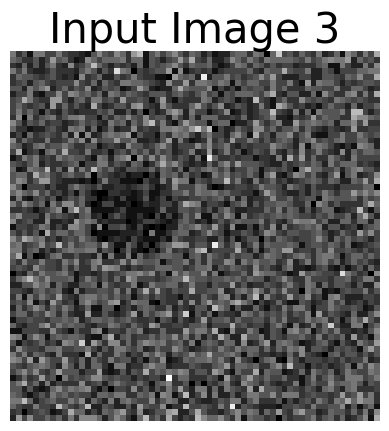

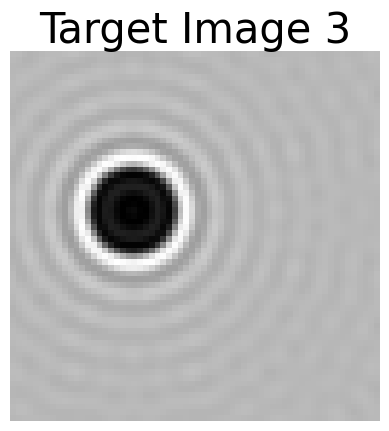

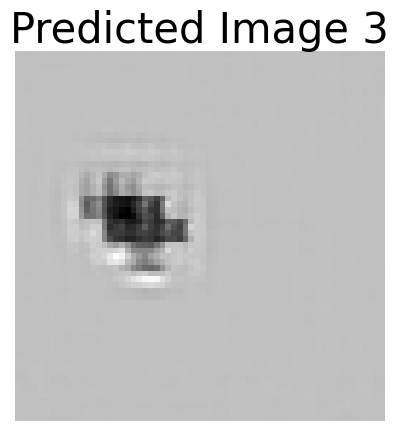

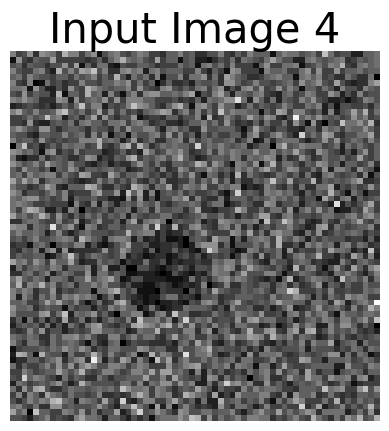

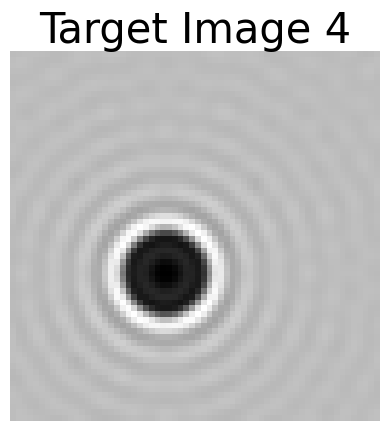

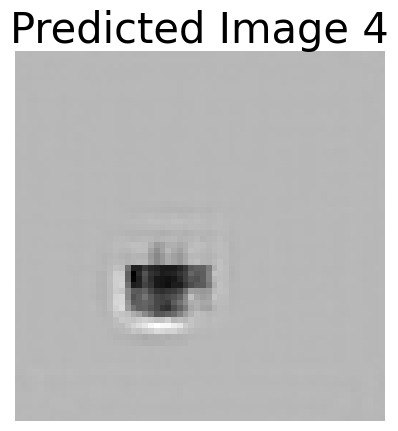

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pip.update().resolve()
    diverse_predicted = ed(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])

## Improving the Training

Train with the dataset with varying parameters ...

In [ ]:
diverse_dataset = SimulatedDataset(diverse_pip, buffer_size=256, replace=0.1)
diverse_loader = torch.utils.data.DataLoader(diverse_dataset, batch_size=8,
                                             shuffle=True)
diverse_ed = regressor_template.create()
diverse_ed_trainer = dl.Trainer(max_epochs=150, accelerator="auto")
diverse_ed_trainer.fit(diverse_ed, diverse_loader)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name          ┃ Type                          ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ loss          │ L1Loss                        │      0 │ train │
│ 1 │ train_metrics │ MetricCollection              │      0 │ train │
│ 2 │ val_metrics   │ MetricCollection              │      0 │ train │
│ 3 │ test_metrics  │ MetricCollection              │      0 │ train │
│ 4 │ model         │ ConvolutionalEncoderDecoder2d │  9.3 K │ train │
│ 5 │ optimizer     │ Adam                          │      0 │ train │
└───┴───────────────┴───────────────────────────────┴────────┴───────┘

Trainable params: 9.3 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.3 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 33                                                                                          
Modules in eval mode: 0

Output()

... and plot the images obtained with the improved training.

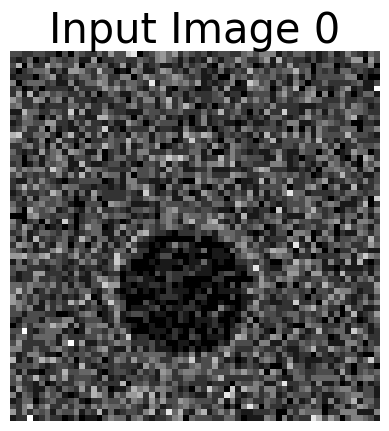

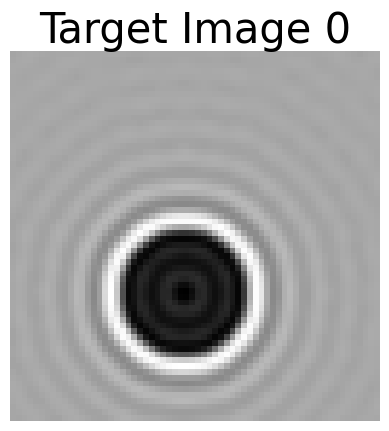

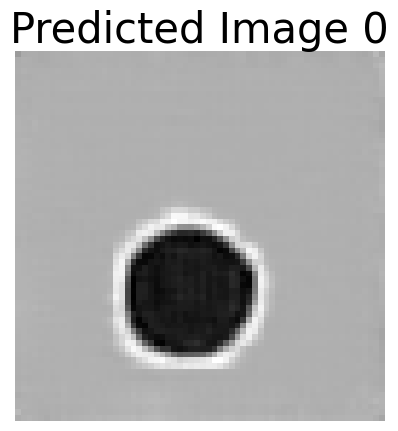

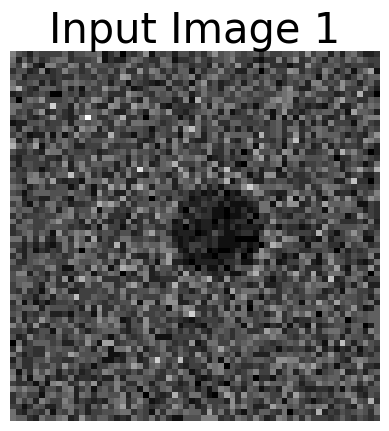

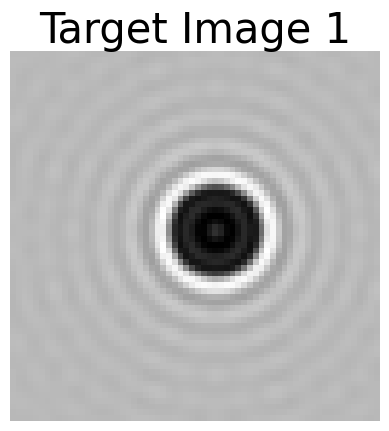

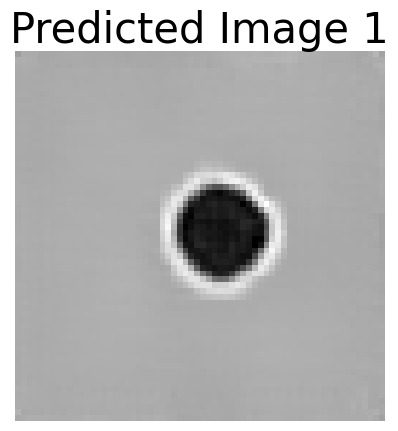

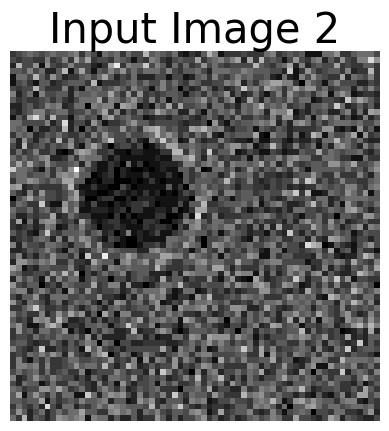

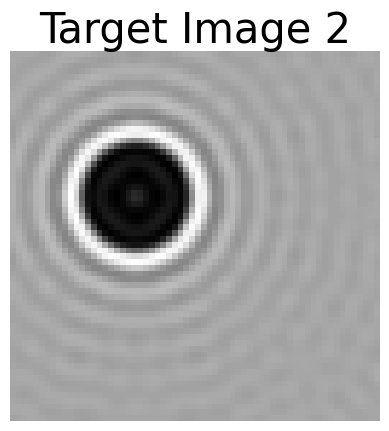

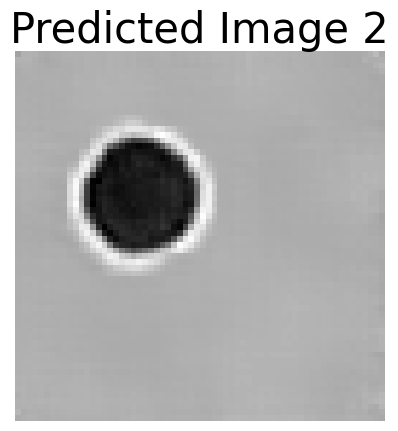

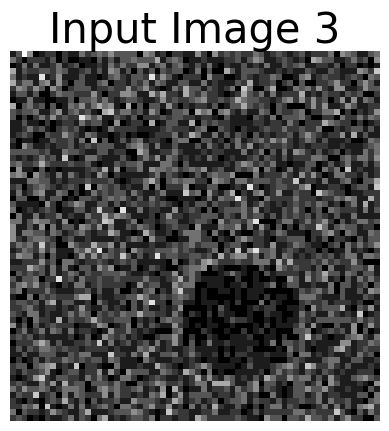

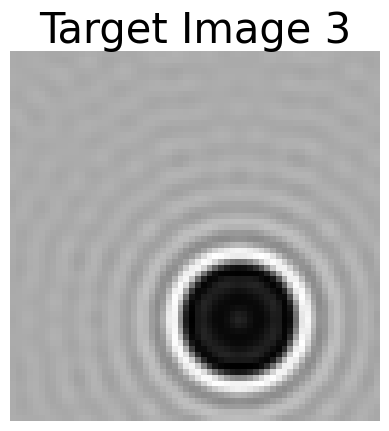

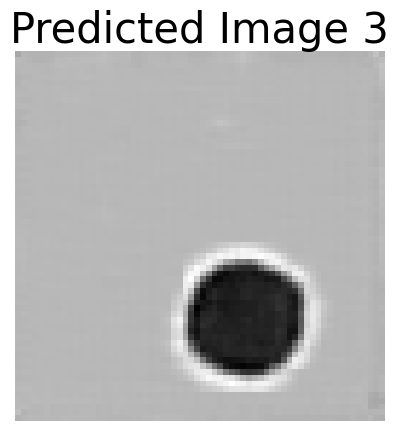

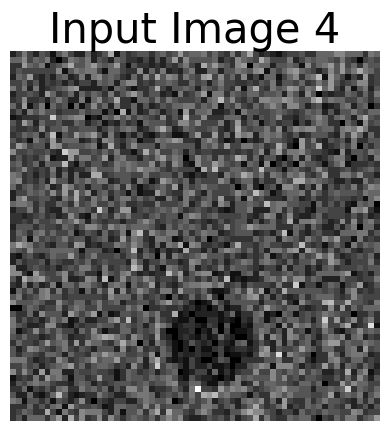

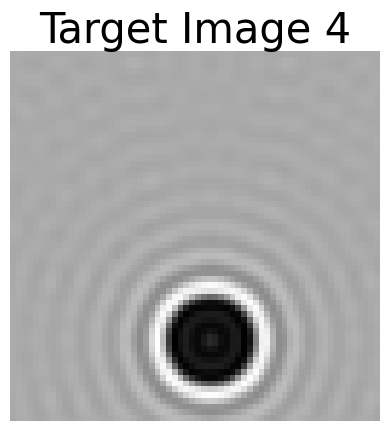

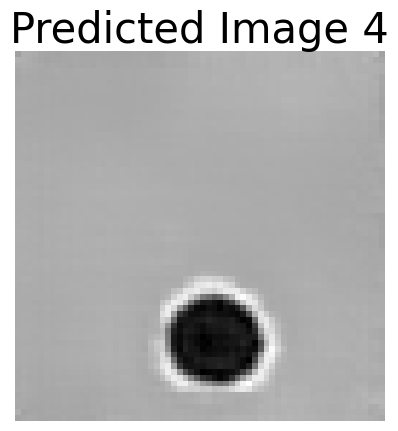

In [ ]:
for i in range(5):
    diverse_input, diverse_target = diverse_pip.update().resolve()
    diverse_predicted = diverse_ed(diverse_input.unsqueeze(0)).detach()

    plot_image(f"Input Image {i}", diverse_input[0, :, :])
    plot_image(f"Target Image {i}", diverse_target[0, :, :])
    plot_image(f"Predicted Image {i}", diverse_predicted[0, 0, :, :])